In [22]:
from warnings import simplefilter
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pmdarima import AutoARIMA
from sklearn.metrics import mean_squared_error
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Sale'>)

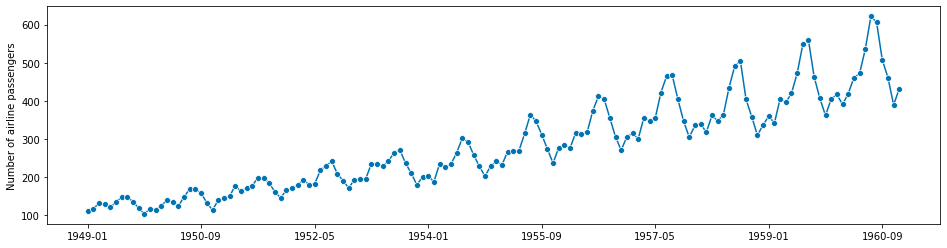

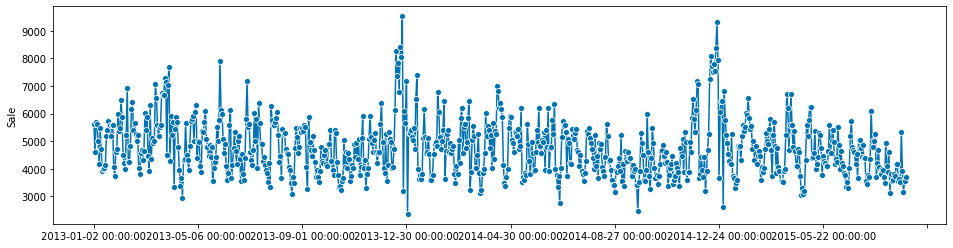

In [2]:
#test
y= load_airline()
file = "C:/Users/gurpr/Videos/BetaSci/Rossmann_Store1_Data_FULL.csv"
pwd = os.getcwd()
os.chdir(os.path.dirname(file))
df = pd.read_csv(os.path.basename(file), header = 0, parse_dates=True, index_col = 0, squeeze = True)
#series = pd.Series(data=['Sale'], index=file.index)
df = df.sort_index()

df.iloc[0]
plot_series(y)
plot_series(df)
#print(series.head())
#series.index=series.index.map(str)
#series.plot()

In [3]:
y.index

PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10',
             ...
             '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
             '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', name='Period', length=144, freq='M')

In [4]:
df.index = df.index.to_period("D")
df.index

PeriodIndex(['2013-01-02', '2013-01-03', '2013-01-06', '2013-01-07',
             '2013-01-08', '2013-01-10', '2013-01-11', '2013-01-14',
             '2013-01-15', '2013-01-16',
             ...
             '2015-11-03', '2015-11-04', '2015-11-05', '2015-11-06',
             '2015-11-07', '2015-12-01', '2015-12-02', '2015-12-03',
             '2015-12-05', '2015-12-06'],
            dtype='period[D]', name='Date', length=780, freq='D')

108 36
float64


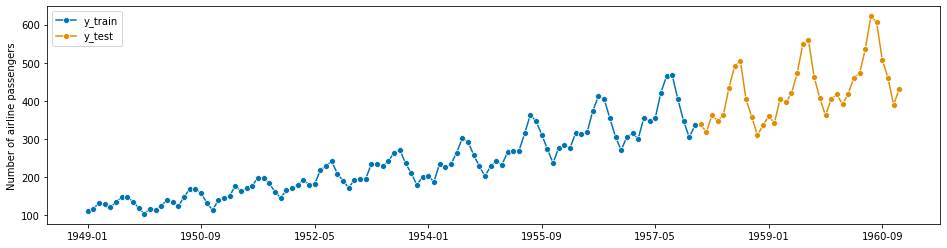

In [5]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
#y_train.plot()
#y_test.plot()
print(y_train.shape[0], y_test.shape[0])
print(y_train.dtype)

585 195
float64


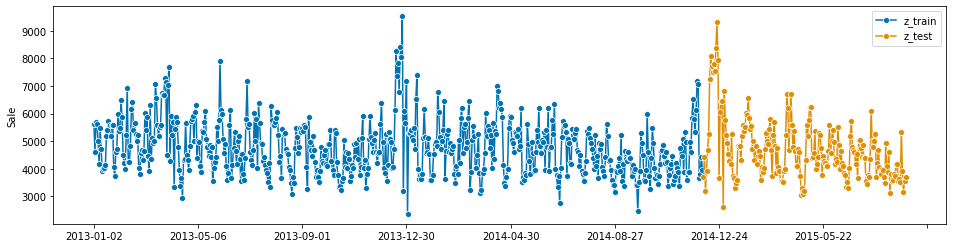

In [6]:
z_train, z_test = temporal_train_test_split(df, test_size=195)
plot_series(z_train, z_test, labels=["z_train", "z_test"])
#print(z_train.shape[0], z_test.shape[0])
#print('train_length:',z_train.shape, '\n test_length:', z_test.shape)
z_train = z_train.astype(np.float64)
#print(z_train.dtype)

In [7]:
fh = np.arange(len(y_test)) + 1
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

In [8]:
fz = np.arange(len(z_test)) +1
#fz = ForecastingHorizon(z_test .index, is_relative=False)
fz

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [46]:
def smape(A, F):
    return (100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F))))/100

0.23195770387951434
121.13857996342682


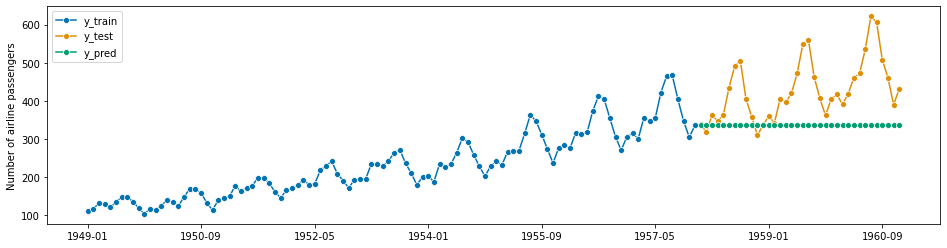

In [65]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
#print(y_pred)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(smape(y_pred, y_test))
print(mean_squared_error(y_test, y_pred, squared=False))

2014-12-06    3957.0
2014-12-07    3957.0
2014-12-08    3957.0
2014-12-09    3957.0
2014-12-10    3957.0
               ...  
2015-06-14    3957.0
2015-06-15    3957.0
2015-06-16    3957.0
2015-06-17    3957.0
2015-06-18    3957.0
Freq: D, Length: 195, dtype: float64
0.15872569769690917
1753612.1897435898


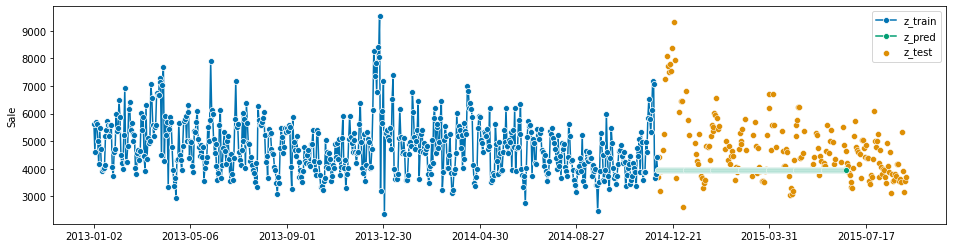

In [49]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(z_train)
z_pred = forecaster.predict(fz)
print(z_pred)
plot_series(z_train, z_test, z_pred, labels=["z_train", "z_test", "z_pred"])
print(smape(z_pred, z_test))
print(mean_squared_error(z_test, z_pred, squared=False))

In [ ]:
out = z_pred.astype(np.int)
out.round()
print(out)
out.to_csv(r'C:\Users\gurpr\Videos\BetaSci\naive_pred.csv', index=False, header=True)

0.051443414498918066
27.368060163177738


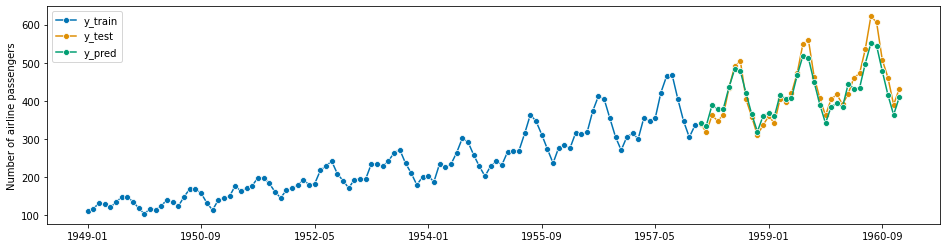

In [62]:
forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(smape(y_pred, y_test))
print(mean_squared_error(y_test, y_pred, squared=False))


C:\Users\gurpr\Videos\BetaSci\venv38\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


(195,)
0.2292408873728412
1874.5697169169875


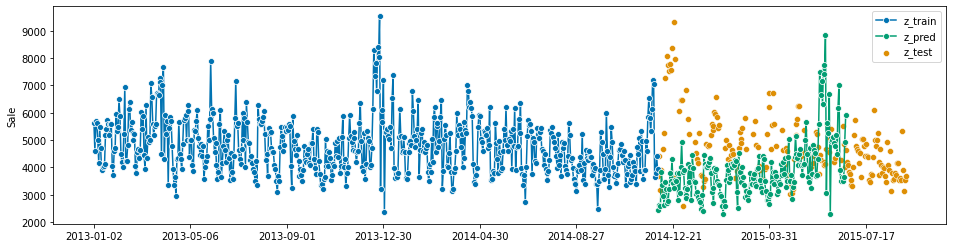

In [64]:
forecaster = ExponentialSmoothing(trend="mul", seasonal="mul", sp=290) #sp=365
#forecaster = ExponentialSmoothing(trend=None,
                                  #seasonal=None, sp=None)
forecaster.fit(z_train)
z_pred = forecaster.predict(fz)
#print(z_pred)
#z_pred.round()
#z_pred = z_pred.astype(np.int)
#print(z_test)
print(z_pred.shape)
plot_series(z_train, z_test, z_pred, labels=["z_train", "z_test", "z_pred"])
print(smape(z_pred, z_test))
print(mean_squared_error(z_test, z_pred, squared=False))



In [72]:
#test sp values
# Lowest RMSE for sp 208 and lowest smape for sp = 26
for x in range (2,292):
    forecaster = ExponentialSmoothing(trend="mul", seasonal="mul", sp=x) #sp=365
    forecaster.fit(z_train)
    z_pred = forecaster.predict(fz)
    #print(z_pred.shape)
    #plot_series(z_train, z_test, z_pred, labels=["z_train", "z_test", "z_pred"])
    print("For sp: " + str(x) + "is " + str(round(smape(z_pred, z_test),3)) + " and " +
          str(round(mean_squared_error(z_test, z_pred, squared=False),0)))

C:\Users\gurpr\Videos\BetaSci\venv38\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\gurpr\Videos\BetaSci\venv38\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\gurpr\Videos\BetaSci\venv38\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\gurpr\Videos\BetaSci\venv38\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\gurpr\Videos\BetaSci\venv38\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\gurpr\Videos\BetaSci\venv38\lib\site-packages\statsmodels\tsa

For sp: 2is 0.277 and 2859.0
For sp: 3is 0.289 and 3010.0
For sp: 4is 1.328 and 4747.0
For sp: 5is 1.316 and 4723.0
For sp: 6is 1.118 and 4325.0
For sp: 7is 1.353 and 38407981.0
For sp: 8is 0.131 and 1171.0
For sp: 9is 0.144 and 1357.0
For sp: 10is 0.795 and 19040.0
For sp: 11is 0.661 and 11874.0
For sp: 12is 0.472 and 6273.0
For sp: 13is 0.186 and 1807.0
For sp: 14is 0.164 and 1287.0
For sp: 15is 0.353 and 2117.0
For sp: 16is 0.243 and 1677.0
For sp: 17is 0.306 and 1936.0
For sp: 18is 0.212 and 2075.0
For sp: 19is 0.222 and 2238.0
For sp: 20is 0.551 and 8322.0
For sp: 21is 0.475 and 6385.0
For sp: 22is 0.384 and 4501.0
For sp: 23is 0.231 and 2311.0
For sp: 24is 0.227 and 2315.0
For sp: 25is 0.159 and 1504.0
For sp: 26is 0.123 and 1158.0
For sp: 27is 0.216 and 1547.0
For sp: 28is 0.132 and 1247.0
For sp: 29is 0.135 and 1352.0
For sp: 30is 0.31 and 3340.0
For sp: 31is 0.344 and 3704.0
For sp: 32is 0.324 and 3631.0
For sp: 33is 0.312 and 3395.0
For sp: 34is 0.369 and 4241.0
For sp: 35is 

ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.

In [ ]:
#Save pandas series to csv file
out = z_pred.astype(np.int)
out.round()
print(out)
out.to_csv(r'C:\Users\gurpr\Videos\BetaSci\es_pred.csv', index=False, header=True)

1153.7492147391474


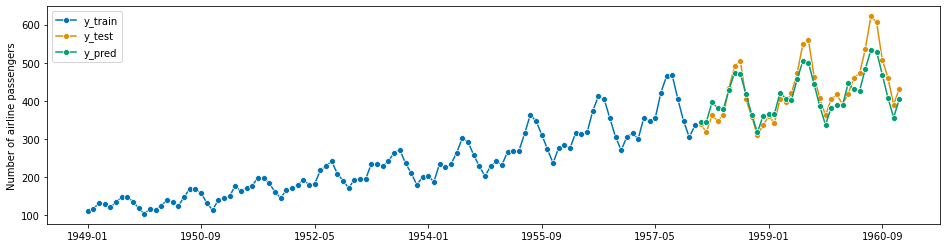

In [33]:
from sktime.forecasting.ets import AutoETS
forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(rmse)

In [ ]:
# from sktime.forecasting.ets import AutoETS
# forecaster = AutoETS(auto=True, n_jobs=-1)
# forecaster.fit(z_train)
# z_pred = forecaster.predict(fz)
# plot_series(z_train, z_test, z_pred, labels=["z_train", "z_test", "z_pred"])
# #smape_loss(z_test, z_pred)
#

In [ ]:
# #Save pandas series to csv file
# out = z_pred.astype(np.int)
# out.round()
# print(out)
# out.to_csv(r'C:\Users\gurpr\Videos\BetaSci\AutoETS_pred.csv', index=False, header=True)

In [ ]:
# forecaster = AutoARIMA(sp=1, suppress_warnings=True, )
# forecaster.fit(y_train)
# y_pred = forecaster.predict(fh)
# plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
# #smape_loss(y_test, y_pred)


2470.2427390280004


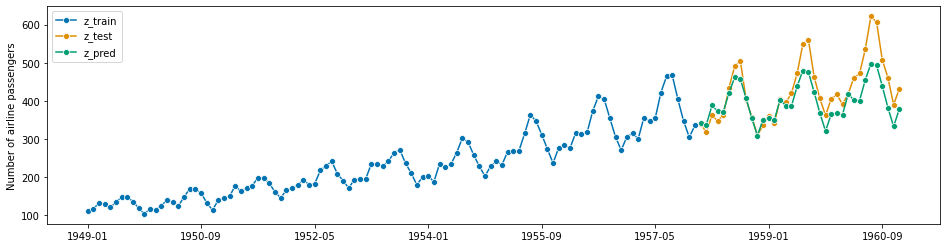

In [34]:
forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
plot_series(y_train, y_test, y_pred, labels=["z_train", "z_test", "z_pred"])
rmse_theta = mean_squared_error(y_test, y_pred, squared=False)
print(rmse_theta)

2394090.039689115
2014-12-06    3958.311713
2014-12-07    4468.597527
2014-12-08    4241.629771
2014-12-09    3473.473013
2014-12-10    3653.172900
                 ...     
2015-06-14    4574.619184
2015-06-15    4595.890383
2015-06-16    3915.244323
2015-06-17    5858.295933
2015-06-18    4282.666236
Freq: D, Length: 195, dtype: float64


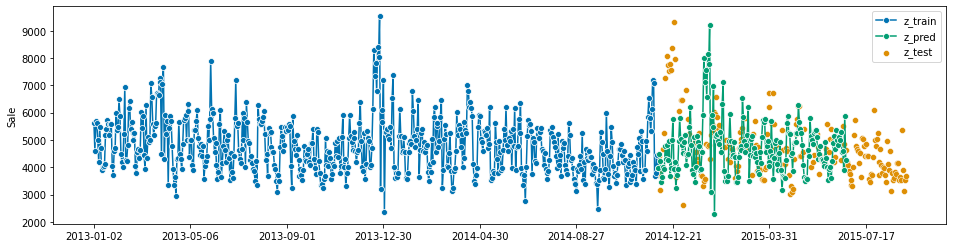

In [35]:
forecaster = ThetaForecaster(sp=230)
forecaster.fit(z_train)
alpha = 0.05  # 95% prediction intervals
z_pred, pred_ints = forecaster.predict(fz, return_pred_int=True, alpha=alpha)
plot_series(z_train, z_test, z_pred, labels=["z_train", "z_test", "z_pred"])
rmse_thetaZ = mean_squared_error(z_test, z_pred, squared=False)
print(rmse_thetaZ)
print(z_pred)

In [ ]:
out = z_pred.astype(np.int)
out.round()
print(out)
out.to_csv(r'C:\Users\gurpr\Videos\BetaSci\theta_pred.csv', index=False, header=True)


In [ ]:
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

In [ ]:
fig, ax = plot_series(z_train, z_test, z_pred, labels=["z_train", "z_test", "z_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();